# Introduction to Generative Adversarial Networks

## Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread”. I’m inclined to believe so because I don’t think sliced bread ever created this much buzz and excitement within the deep learning community.

Generative Adversarial Networks are a set of models that basically learn to create synthetic data that is similar to input data it's given. In more formal terms, a GAN is a generative model that learns the probability distribution (or data distribution) of the training examples it is given. From this distribution, we can then create sample outputs. GANs have seen their largest progress with image training examples, but this idea of modeling data distributions is one that can be applied with other forms of input. In the case described in today’s post, we’ll be creating a GAN that learns to generate synthetic, yet readable, images of MNIST digits.

## Basic GAN Model Architecture

The basic structure of the model is simple. You have a Generator Network component and a Discriminator Network component, as shown below.

!["Basic GAN Architecture"](https://raw.githubusercontent.com/uclaacmai/Generative_Adversarial_Network_Tutorial_2018/master/gan_architecture.png)

The job of the discriminator network, like the name suggests, is to discriminate between "real" images (like those from our dataset) from those that have been artificially created. It is implemented as a neural network, in our example below, that outputs one value representing the probability that the given image is real.

The generator, on the other hand, will try to generate images to "trick" the disciminator, i.e. creating images that look natural or close to real. To achieve this goal, it will eventually learn to output images/data close to the original data distribution.  

This can be thought of as a zero-sum or minimax two player game. The analogy used in the paper is that the generative model is like “a team of counterfeiters, trying to produce and use fake currency” while the discriminative model is like “the police, trying to detect the counterfeit currency”. The generator is trying to fool the discriminator while the discriminator is trying to not get fooled by the generator. As the models train through alternating optimization, both methods are improved until a point where the “counterfeits are indistinguishable from the genuine articles”. There are specific game theory concepts that prove there is indeed an equilibrium to this game where the generator gets so good that the discriminator outputs a probability of ½ for every input.

## Our Task

Today, our goal is to use the MNIST data set as our "real" images to create a GAN model that can generate realistic images of hand drawn digits. The digits will have to look natural enough to fool a classifier that is trying to ditinguish between synthetic and natural images. Ideally, the produced images would be so realistic, that humans cannot distinguish them either.

What we will need:

* Real MNIST training images
* A generator network that takes in a random noise vector and produces a synthetic image
* A discriminator network that learns to distinguish between real and synthetic images, i.e. a binary classifier (1 for real image, 0 for fake)
* An optimization procedure that jointly updates both networks through gradient descent.
* Tensorflow - Our choice of Deep Learning framework

Let's get started!

## Initial Setup

First, we must add out imports. We will mainly be working with Tensorflow, so we have to import that of course. The next line imports the MNIST data set we will be working with. Numpy is always useful when working with matrices, and in this case, to supply us with a random number generator function. Matplotlib gives us the ability to easily visualize our data as graphs.

In [1]:
# canonical import statements
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

#### Placeholders
Next, we create variable placeholders for the inputs to our two models. The purpose of a placeholder is basically to tell Tensorflow "We're going to input in our random z vector later, but for now, we're going to define this placeholder variable instead". It lets Tensorflow know about the size of the inputs beforehand. For example, the shape of the placeholder for our generator will be [None x 100]. The None keyword means that the value can be determined at session runtime. We normally have None as our first dimension so that we can have variable batch sizes (With a batch size of 16, the input to the generator would be 16 x 100). With the None keywoard, we don't have to specify batch_size until later.

In [2]:
# images (for the discriminator)
X = tf.placeholder(tf.float32, shape=[None, 784])
# noise vector (for the generator)
Z = tf.placeholder(tf.float32, shape=[None, 100])

#### Weight Initialization
Before we create our model, it's a good idea to decide on how to initialize our weights. How weights are initialized can affect how effectively our model converges. Here, we have decided to initialize them with "Xavier initialization."

A good motivation for this is as follows: "With each passing layer, we want the variance to remain the same. This helps us keep the signal from exploding to a high value or vanishing to zero. In other words, we need to initialize the weights in such a way that the variance remains the same for x and y. This initialization process is known as Xavier initialization." You can read more about the math and intuitiion [here](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/):

Below is a function we have defined for later use to help us initialize weights from a Gaussian distribution in "xavier" fashion. 

In [3]:
def xavier(shape):
    return tf.truncated_normal(shape = shape, stddev = 1.0/tf.sqrt(shape[0]/2.0)) #"xavier" initialization of weights

## Discriminator Network

!["Discriminator Network Visual Represenation"](https://raw.githubusercontent.com/uclaacmai/Generative_Adversarial_Network_Tutorial_2018/master/discriminator_network.png)

Next, we shall create a simple neural network to act as our discriminator model. Our image we input is 28x28, so a total of 784 input data per image. Thus, our network will have an input layer of size 784, with a hidden layer of size 128, and ultimately output an layer of just 1 single scalar number activation to describe the probability that the image is real. 

We initialize our weights and our biases in "__init__" with xavier initialization for the former and setting all values to zero for the latter. Our "discriminator" function multiplies our weights and inputs accordingly across the layers to give an appropriate output. Finally, "get_trainable_vars" returns the weight and bias variables associated to the model.

In [4]:
class discriminator_network:
    """MNIST IMAGE(s): x * 784 -> 128 hidden units -> 1 output neuron (probability of being real)"""
    def __init__(self):
        self.d_w1 = tf.Variable(xavier([784,128]))
        self.d_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.d_w2 = tf.Variable(xavier([128,1]))
        self.d_b2 = tf.Variable(tf.zeros(shape=[1]))
    
    def discriminator(self, x):
        """Calculate D(x)"""
        d_hfc_1 = tf.nn.relu(tf.matmul(x, self.d_w1) + self.d_b1)
        d_logit = tf.matmul(d_hfc_1, self.d_w2) + self.d_b2
        d_prob = tf.nn.sigmoid(d_logit) # convert the output to a probability
        return d_prob, d_logit
    
    def get_trainable_vars(self):
        return [self.d_w1, self.d_b1, self.d_w2, self.d_b2]

## Generator Network

The generator can be thought of as doing the "opposite" of the discriminator. It will be taking a random noise vector, and "upsampling" it to become a 28x28 "image" that the model learns to generate in a more realistic manner. 

The neural network will take an input size of 100 in its first layer, expand it into a hidden layer of size 128, and ultimately creating an output layer with the same size as the MNIST image data, 784.

Once again, our "__init__" sets the weights and biases, the generator returns the appropriate outputs from the network, and "get_trainable_vars" returns the weight and bias variables of the model.

In [5]:
class generator_network:
    """Random noise vector (100 dim assumed) -> expand to 128 units -> output 784 units (MNIST dim)"""
    def __init__(self):
        self.g_w1 = tf.Variable(xavier([100, 128])) # 100d noise vector assumed. Output 128 hidden units in first layer
        self.g_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.g_w2 = tf.Variable(xavier([128, 784])) # 784 outputs
        self.g_b2 = tf.Variable(tf.zeros(shape=[784]))
    
    def generator(self, z):
        """Calculate and sample G(z)"""
        g_hfc_1 = tf.nn.relu(tf.matmul(z, self.g_w1) + self.g_b1) # 100 * 128 here
        return tf.nn.sigmoid(tf.matmul(g_hfc_1, self.g_w2) + self.g_b2)
    
    def get_trainable_vars(self):
        return [self.g_w1, self.g_b1, self.g_w2, self.g_b2]

How do we get the random noise vector for the generator you might ask? We make a function for it below, using Numpy's numpy.random library. We want a uniform distribution from range -1.0 to 1.0.

In [6]:
# next, we need a function to actually generate a 100d noise vector to feed into our generator
def rand_noise_vector(num_vectors, size):
    return np.random.uniform(-1.0, 1.0, size = [num_vectors, size]) # we might want a bunch of these to generate many imgs

Also, it would be really boring to generate all these images if we couldn't see any of it, so we write a function to plot our image data with matplotlib.pyplot. We can also save our figures with savefig( ) if we like.

In [7]:
# a function to plot the genned images
def plot(samples, cur_epoch = None):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        # if epoch is not specified we just overwrite the existing image
        plt.savefig("gan{}".format("" if cur_epoch is None else cur_epoch))
        plt.show()

    return fig

## Training the GAN

Here's the important part, where we define our networks and cost functions. First, let's create instances of both the generator and discriminator network, and sample a generated image, an output prediction on a real image, and an output prediction on a fake image. 

In [8]:
# create networks
gen_net, discriminator_net = generator_network(), discriminator_network()
# compute G(z) where z is the random noise vector 
g_sample = gen_net.generator(z=Z) # this is G(z)
# compute d(real) = p(image being real)
_, d_logit_real = discriminator_net.discriminator(X) # this is D(x)
# compute d(fake) = p(image being real)
_, d_logit_fake = discriminator_net.discriminator(g_sample) # this is D(G(z))

As mentined in the [slides](https://docs.google.com/presentation/d/17sHIVbt8WN7fEUs9rnhwV6god4493xEjUt9aCYJ4BYM/edit?usp=sharing) we'd like the optimize the generator such that $D(G(z))$ is high. This is equivalent to maximizing the log probability $\log(D(G(z))$, or minimizing $1 - \log(D(G(z))$. The `tf.nn.sigmoid_cross_entropy` function will normalize our output logits from our generator and compute this loss function for us. Intuitively, we'd want the cross entropy between $D(G(z))$ and a vector of $1$'s to be zero, this would indicate that we've fooled the discriminator.

The reduce mean function just takes the mean value of all of the components in the matrix returned by the cross entropy function. This is just a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [9]:
# train the generator w/fake logits
# cross entropy between D(G(z))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.ones_like(d_logit_fake)))

Now, let’s think about the discriminator’s point of view. We'd like to optimize is so that $D(x)$ is high and $D(G(z))$ is small, so we can try to maximize $\log D(x) + \log(1 - D(G(z))$. This means that we'd like the cross entropy between $D(x)$ and a vector of $1$ 1's to be zero, and the cross entropy between $D(G(z))$ and a vector of $0$'s to be zero.

In [10]:
# optimize wrspt to the real logits, so all tha labels are one since we knew they came from real samples
d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels = tf.ones_like(d_logit_real)))
# optimize wrspt to the fake logits, so all the labels are zero since we knew that they came from fake (generated) samples
d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.zeros_like(d_logit_fake)))
# total loss is just the sum
d_loss = d_real_loss + d_fake_loss

Next, we specify our optimizers. We'll use the Adam Optimizer, which provides an adaptive learning rate and momentum out of the box. We'll also make sure that if we're optimizing the discriminator, then the generator variables are held constant, and vice versa. We'll do this by explicitly passing in a `var_list` to each `minimize` call. 

In [11]:
# make sure to only train w/relevant vars
adam = tf.train.AdamOptimizer()
d_step = adam.minimize(d_loss, var_list = discriminator_net.get_trainable_vars())
g_step = adam.minimize(g_loss, var_list = gen_net.get_trainable_vars())

Wait... what are we training on again? Oh right! MNIST! Almost forgot...

We should probably load our MNIST data set then. To do this, we’ll call a TF function called read_data_sets. This loads in the 55,000 training examples in the MNIST database.

#### MNIST, MNIST, MNIST

In [12]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


#### Train and Run Our Model

Okay, let's run finally run our model. We will create a Tensorflow session with tf.Session()

We will train is with 100,000 epochs, and print out its progress every 1000 epochs, along with a sample image produced by our current generator network. 

In the end of our training, we print out 16 sample synthetic images. Wow... so natural, so real, so pleasing, so aesthetic. Don't they look like REAL hand written numbers? Real, human-like ugly handwriting, produced by your own machine learning model. Good job! 

Epoch: 0
Discriminator loss: 1.522985577583313
Generator loss: 1.7351818084716797


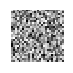

Epoch: 1000
Discriminator loss: 0.10210137069225311
Generator loss: 3.9842605590820312


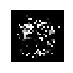

Epoch: 2000
Discriminator loss: 0.21843285858631134
Generator loss: 3.7385568618774414


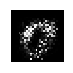

Epoch: 3000
Discriminator loss: 0.4937973618507385
Generator loss: 2.6894006729125977


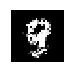

Epoch: 4000
Discriminator loss: 1.354386806488037
Generator loss: 2.4238088130950928


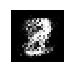

Epoch: 5000
Discriminator loss: 1.3319649696350098
Generator loss: 1.3066492080688477


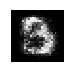

Epoch: 6000
Discriminator loss: 1.3624396324157715
Generator loss: 1.3443700075149536


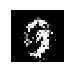

Epoch: 7000
Discriminator loss: 1.3199636936187744
Generator loss: 0.8287303447723389


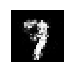

Epoch: 8000
Discriminator loss: 1.355851173400879
Generator loss: 0.8837842345237732


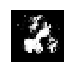

Epoch: 9000
Discriminator loss: 1.329987645149231
Generator loss: 0.770551860332489


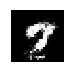

Epoch: 10000
Discriminator loss: 1.206045150756836
Generator loss: 1.160016417503357


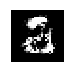

Epoch: 11000
Discriminator loss: 1.2795729637145996
Generator loss: 0.9333118200302124


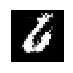

Epoch: 12000
Discriminator loss: 1.2569644451141357
Generator loss: 0.8906954526901245


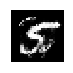

Epoch: 13000
Discriminator loss: 1.1708159446716309
Generator loss: 1.438151478767395


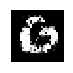

Epoch: 14000
Discriminator loss: 1.1851078271865845
Generator loss: 0.9700734615325928


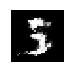

Epoch: 15000
Discriminator loss: 1.251354694366455
Generator loss: 0.9710195064544678


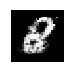

Epoch: 16000
Discriminator loss: 1.2397825717926025
Generator loss: 0.8814488649368286


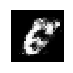

Epoch: 17000
Discriminator loss: 1.2393574714660645
Generator loss: 0.8753318190574646


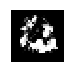

Epoch: 18000
Discriminator loss: 1.2562850713729858
Generator loss: 0.965623676776886


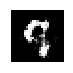

Epoch: 19000
Discriminator loss: 1.2001712322235107
Generator loss: 0.9724262952804565


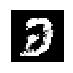

Epoch: 20000
Discriminator loss: 1.1771996021270752
Generator loss: 1.0974690914154053


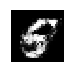

Epoch: 21000
Discriminator loss: 1.2189044952392578
Generator loss: 1.0727733373641968


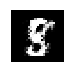

Epoch: 22000
Discriminator loss: 1.0596990585327148
Generator loss: 1.0905258655548096


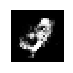

Epoch: 23000
Discriminator loss: 1.050118327140808
Generator loss: 1.269740104675293


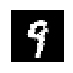

In [ ]:
%matplotlib inline
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = 0
    for epoch in range(100000):
        X_mb, _ = mnist.train.next_batch(128)
        _, cur_loss_d = sess.run([d_step, d_loss], feed_dict = {X: X_mb, Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        if epoch % 1000 == 0:
            print("Epoch: {}".format(epoch))
            print("Discriminator loss: {}".format(cur_loss_d))
            print("Generator loss: {}".format(cur_loss_g))
            samples = sess.run(g_sample, feed_dict={Z: rand_noise_vector(1, 100)})
            plot(samples, epoch)
    samples = sess.run(g_sample, feed_dict={Z: rand_noise_vector(16, 100)})
    plot(samples) # 16 of em

#### Exercises
- Try changing up the discriminator model. In particular, what happens if you add more hidden or convolutional layers to the discriminator network?
- Read up about deconvolutions/transposed convolutions and try to implement a convolutional architecture for the generator. If you do this, you will get something close to the DCGAN architecture. 

## Closing Thoughts
In this post, we showed how two networks were able to play a minimax game in order to capture the data distribution of the MNIST digits and generate similar looking samples. With applications in video frame prediction, text-image mappings, and more, GANs are definitely the hottest topic in deep learning. Hopefully, with this tutorial, you’ve gained a better understanding of how these networks work in practice and how you can build your own with Tensorflow!